In [33]:
import os
from torchvision import datasets, models, transforms
import torch
import torchvision
import numpy as np

In [10]:
np_epochs = 100

is_gpu_available = torch.cuda.is_available()
print 'is_gpu_available: ', torch.cuda.is_available()

is_gpu_available:  True


# Load images
1. Define a transformer
2. Define a dataloader

Pay special attention to the comments.

In [7]:
# this is required by pre-trained models like VGG
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224), # this is critical as you will otherwise end up with different size tensors
    transforms.ToTensor() # this is needed to get output as tensors
])

val_trans = transforms.Compose([
    transforms.RandomSizedCrop(224), # this is critical as you will otherwise end up with different size tensors
    transforms.ToTensor() # this is needed to get output as tensors
])

In [10]:
# downloaded from https://download.pytorch.org/tutorial/hymenoptera_data.zip
# from http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_dir = 'data/hymenoptera_data/'

In [11]:
train_dataset = datasets.ImageFolder(data_dir + 'train', train_trans)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

val_dataset = datasets.ImageFolder(data_dir + 'val', val_trans)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

# Visualize the data you loaded
This is generic enough to move somewhere central for reuse

In [5]:
# once you get the images out of the data loader use this to get a batch out
# make this generic enough
import matplotlib.pyplot as plt
%matplotlib inline

def plot(images, title=None):
    images = images.numpy().transpose(1,2,0)
    plt.figure(figsize=(15,15))
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    # show titles
    if title != None:
        plt.title(title)
    plt.pause(0.001)


# e.g. given a dataloader this is how you would show a batch of images
#inp, classes = next(iter(train_data_loader))
#imgs = torchvision.utils.make_grid(inp)
#labels = [train_dataset.classes[x] for x in classes]
#plot(imgs, labels)

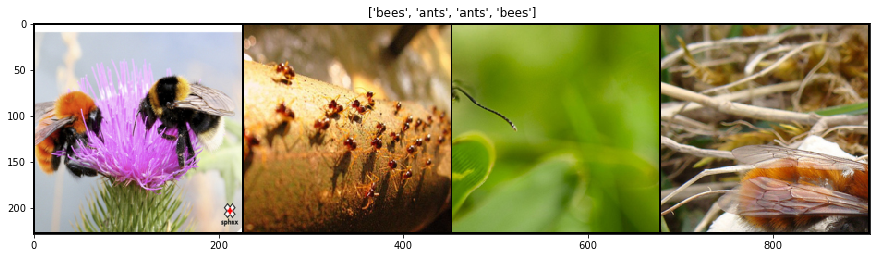

In [6]:
# visualize some train examples 
inp, classes = next(iter(train_data_loader))
imgs = torchvision.utils.make_grid(inp)

labels = [train_dataset.classes[x] for x in classes]
plot(imgs, labels)

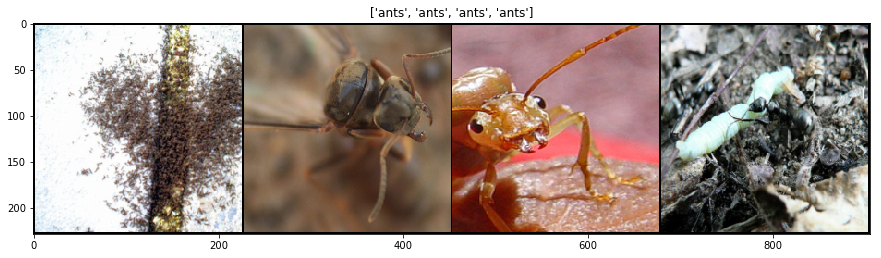

In [7]:
# visualize some train examples 
inp, classes = next(iter(val_data_loader))
imgs = torchvision.utils.make_grid(inp)

labels = [val_dataset.classes[x] for x in classes]
plot(imgs, labels)

# Simple CNN model

In [8]:
import torch.nn as nn
from torch.autograd import Variable

np_epochs = 500

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(0.25)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(128*14*14, 128),
            nn.Dropout2d(.3),
            nn.Linear(128, 2)
        )
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.size()) # use this to find the structure you will use to generate the size of the FC layer
        
        # flatten before using the fully connected layer
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        return out

In [19]:
# Evaluation
def evaluate(cnn, val_data_loader, use_gpu=False):
    
    # lock the model?
    cnn.eval()

    total_pred = 0
    total_correct = 0

    class_pred_counter = {}
    total_pred_counter = {}
    correct_pred_counter = {}

    corr_pos_pred = 0
    pred_pos = 0
    lbl_pos = 0

    # evaluate the model
    for images, classes in val_data_loader:
        imgs = None
        lbls = None
 
        if use_gpu == True:
            imgs = Variable(images).cuda()
            lbls = Variable(classes).cuda()
        else:
            imgs = Variable(images)
            lbls = Variable(classes)

        outputs = cnn(imgs)
        #print(outputs.data.numpy())

        # max get the maximum of a row (1) or column (0)
        # max returns the maximum value, and actual max value
        _, predicted =  torch.max(outputs.data, 1)
        correct = (predicted == lbls.data).sum()
        total = predicted.size()[0]

        for i in range(lbls.data.size()[0]):
            lbl = lbls.data[i]
            pred = predicted[i]

            if lbl not in total_pred_counter:
                total_pred_counter[lbl] = 0
                correct_pred_counter[lbl] = 0

            if pred not in class_pred_counter:
                class_pred_counter[pred] = 0

            if pred == 1:
                pred_pos += 1
                if pred == lbl:
                    corr_pos_pred += 1
            if lbl == 1:
                lbl_pos += 1

            total_pred_counter[lbl] += 1
            class_pred_counter[pred] += 1
            correct_pred_counter[lbl] += (lbl == pred)

            #print lbl, pred

        total_correct += correct 
        total_pred += total

    print total_correct
    print total_pred 
    print
    print total_correct*1.0/total_pred

    print 'total: ', total_pred_counter
    print 'pred:  ', class_pred_counter
    print 'corr:  ', correct_pred_counter
    print 
    print 'corr_pos_labels: ', corr_pos_pred
    print 'pos_labels: ', lbl_pos
    print 'pos_pred: ', pred_pos

    print 'precision: ', (corr_pos_pred*1.0/pred_pos)
    print 'recall: ', (corr_pos_pred*1.0/lbl_pos)

# Running on CPU

In [ ]:
cnn = CNN()
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(np_epochs):
    i = 0
    for imgs, classes in train_data_loader:
        imgs = Variable(imgs)
        lbls = Variable(classes)
        
        opt.zero_grad()
        output = cnn(imgs)

        loss = criterion(output, lbls)
        #print(loss.data[0])
        loss.backward()
        opt.step()
        
        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, np_epochs, i+1, len(train_dataset)//4, loss.data[0]))
        i+=1

evaluate(cnn, val_data_loader, use_gpu=False)

# Now on GPU
Same as the CPU with all the variables and net

In [17]:
cnn = CNN()
cnn.cuda()

criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(np_epochs):
    i = 0
    for imgs, classes in train_data_loader:
        imgs = Variable(imgs).cuda()
        lbls = Variable(classes).cuda()
        
        opt.zero_grad()
        output = cnn(imgs)

        loss = criterion(output, lbls)
        #print(loss.data[0])
        loss.backward()
        opt.step()

        
        if (i+1) % 40 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, np_epochs, i+1, len(train_dataset)//4, loss.data[0]))
        i+=1


Epoch [1/100], Iter [40/61] Loss: 0.7584
Epoch [2/100], Iter [40/61] Loss: 0.5752
Epoch [3/100], Iter [40/61] Loss: 0.6531
Epoch [4/100], Iter [40/61] Loss: 0.7121
Epoch [5/100], Iter [40/61] Loss: 0.7812
Epoch [6/100], Iter [40/61] Loss: 1.1724
Epoch [7/100], Iter [40/61] Loss: 1.7385
Epoch [8/100], Iter [40/61] Loss: 0.5107
Epoch [9/100], Iter [40/61] Loss: 1.7506
Epoch [10/100], Iter [40/61] Loss: 0.4178
Epoch [11/100], Iter [40/61] Loss: 0.5160
Epoch [12/100], Iter [40/61] Loss: 0.7139
Epoch [13/100], Iter [40/61] Loss: 0.4323
Epoch [14/100], Iter [40/61] Loss: 0.9363
Epoch [15/100], Iter [40/61] Loss: 0.7874
Epoch [16/100], Iter [40/61] Loss: 0.2352
Epoch [17/100], Iter [40/61] Loss: 0.6232
Epoch [18/100], Iter [40/61] Loss: 0.7186
Epoch [19/100], Iter [40/61] Loss: 0.8057
Epoch [20/100], Iter [40/61] Loss: 0.6496
Epoch [21/100], Iter [40/61] Loss: 0.5955
Epoch [22/100], Iter [40/61] Loss: 0.3552
Epoch [23/100], Iter [40/61] Loss: 0.5698
Epoch [24/100], Iter [40/61] Loss: 0.7375
E

CNN (
  (layer1): Sequential (
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU ()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU ()
  )
  (layer2): Sequential (
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Dropout2d (p=0.25)
  )
  (layer3): Sequential (
    (0): Linear (25088 -> 128)
    (1): Dropout2d (p=0.3)
    (2): Linear (128 -> 2)
  )
)

In [20]:
evaluate(cnn, val_data_loader, use_gpu=True)

96
153

0.627450980392
total:  {0: 70, 1: 83}
pred:   {0: 109, 1: 44}
corr:   {0: 61, 1: 35}

corr_pos_labels:  35
pos_labels:  83
pos_pred:  44
precision:  0.795454545455
recall:  0.421686746988


# Load a pretrained model (VGG in this case)

In [59]:
from torchvision.models import vgg

# load a pretrained vgg 16 model
model = models.__dict__['vgg16'](pretrained=True)
# lets put it on the GPU
model.cuda()

# the model has two parts, conv layers -> features and fc layers -> classifier
# one can either stop the weights of the full model or parts of by doing one of the following pieces of code below

# make all the layers untrainable
#for p in model.features.parameters():
# make only feature layer params untrainable
for p in model.features.parameters():
    p.requires_grad = False

# lock the model for evaluation
model.eval()

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [64]:
print model.features
print model

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

In [62]:
# lets load some a batch example
imgs,labels = next(iter(train_data_loader))

In [63]:
from torch.autograd import Variable

cd_imgs = Variable(imgs).cuda()

# predict the output of the classifier
pred_class = model(cd_imgs)
print(pred_class.size())

pred_feat = model.features(cd_imgs)
print(pred_feat.size())

torch.Size([4, 1000])
torch.Size([4, 512, 7, 7])
